In [2]:
!pip install pytorchts -q

     |████████████████████████████████| 92kB 10.3MB/s 
     |████████████████████████████████| 901kB 37.0MB/s 
     |████████████████████████████████| 1.8MB 45.5MB/s 
     |████████████████████████████████| 10.1MB 49.0MB/s 
     |████████████████████████████████| 102kB 13.7MB/s 
     |████████████████████████████████| 133kB 53.5MB/s 
     |████████████████████████████████| 174kB 50.0MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 


In [3]:
import requests
url = 'https://raw.githubusercontent.com/vpozdnyakov/probabilistic_forecasting/main/models/metrics.py'
open('metrics.py', 'wb').write(requests.get(url).content);

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.base.transform import BoxCox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.stattools import pacf
from metrics import quantile_loss

import warnings
warnings.filterwarnings('ignore', category=InterpolationWarning)

from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.common import ListDataset

import torch
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer
device = 'cuda'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [5]:
aus_retail = pd.read_csv('https://raw.githubusercontent.com/vpozdnyakov/probabilistic_forecasting/main/datasets/aus_retail.csv',  index_col=0)
aus_retail.index = pd.to_datetime(aus_retail.index)

In [6]:
train_start = pd.Timestamp('1982-04-01')
train_end = pd.Timestamp('2016-02-01')
test_start = pd.Timestamp('2011-02-01')

In [7]:
train = aus_retail[aus_retail.index <= train_end].iloc[:, :4]
test = aus_retail[aus_retail.index > train_end].iloc[:, :4]
train.shape, test.shape

((407, 4), (60, 4))

### Without scaling

In [8]:
t_train = train.copy()

In [9]:
train_ds = ListDataset(
    [{'target': ts, 'start': train_start} for ts in t_train.values.T],
    freq='M')

test_ds = ListDataset(
    [{'target': ts, 'start': test_start} for ts in t_train.values[-60:].T],
    freq='M')

In [18]:
train_grouper = MultivariateGrouper(
    max_target_dim=4)
test_grouper = MultivariateGrouper(
    max_target_dim=4)

dataset_train = train_grouper(train_ds)
dataset_test = test_grouper(test_ds)

In [19]:
estimator = TransformerTempFlowEstimator(
    input_size=14,
    d_model=16,
    num_heads=4,
    target_dim=4,
    prediction_length=60,
    context_length=60,
    flow_type='MAF',
    dequantize=True,
    freq='M',
    trainer=Trainer(
        device=device,
        epochs=16,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64))

In [20]:
predictor = estimator.train(dataset_train)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)
98it [00:07, 13.75it/s, avg_epoch_loss=-3.7, epoch=0] 
98it [00:06, 14.27it/s, avg_epoch_loss=-5.86, epoch=1]
98it [00:06, 14.12it/s, avg_epoch_loss=-7.22, epoch=2]
98it [00:06, 14.16it/s, avg_epoch_loss=-8.02, epoch=3]
98it [00:06, 14.12it/s, avg_epoch_loss=-8.4, epoch=4] 
98it [00:06, 14.15it/s, avg_epoch_loss=-9.16, epoch=5]
98it [00:06, 14.11it/s, avg_epoch_loss=-9.72, epoch=6]
98it [00:06, 14.08it/s, avg_epoch_loss=-10.1, epoch=7]
98it [00:06, 14.18it/s, avg_epoch_loss=-10.5, epoch=8]
98it [00:06, 14.10it/s, avg_epoch_loss=-10.8, epoch=9]
98it [00:06, 14.18it/s, avg_epoch_loss=-11.1, epoch=

In [21]:
forecasts = list(predictor.predict(dataset_test, num_samples=1000))
forecast = forecasts[0].samples
proba_forecast = np.quantile(forecast, q=[0.025, 0.5, 0.975], axis=0, )
point_forecast = proba_forecast[1]
lower_forecast = proba_forecast[0]
upper_forecast = proba_forecast[2]

/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)


In [22]:
pred = pd.DataFrame(
    point_forecast, columns=test.columns, index=test.index[-60:])
lower = pd.DataFrame(
    lower_forecast, columns=test.columns, index=test.index[-60:])
upper = pd.DataFrame(
    upper_forecast, columns=test.columns, index=test.index[-60:])

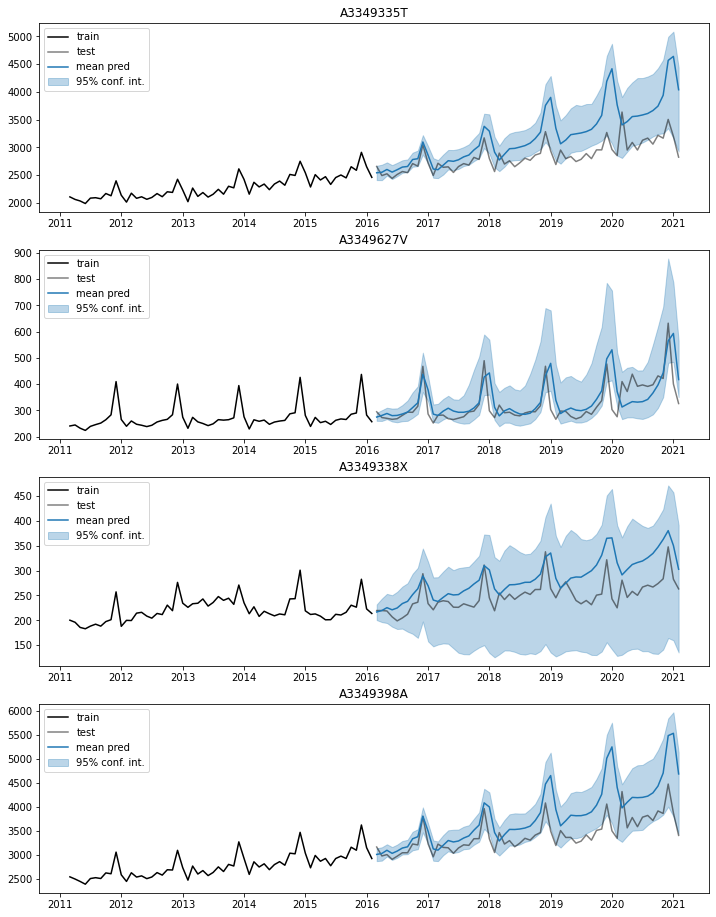

In [23]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-60:], c='black', label='train')
    plt.plot(test[col].iloc[-60:], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(pred.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)

In [28]:
y_pred = np.stack([lower.values, pred.values, upper.values], axis=2)
print('Quantile loss: {:.4f}'.format(quantile_loss(y_pred, test.values)))

Quantile loss: 0.1640


In [35]:
gen_corr = np.corrcoef(forecast.reshape(4, 1000*60))
test_corr = np.corrcoef(test.values.T)

print('Correlation loss: {:.4f}'.format(mse(gen_corr, test_corr)))

Correlation loss: 0.0084


In [36]:
generated_ts = forecast

nlags = 20
nts = generated_ts.shape[2]
ngen = generated_ts.shape[0]
gen_pacfs = np.zeros((ngen, nts, nlags))
for gen_id in range(ngen):
    for ts_id in range(nts):
        gen_pacfs[gen_id, ts_id] = pacf(generated_ts[gen_id, :, ts_id], nlags=nlags)[1:]
gen_pacfs = gen_pacfs.mean(axis=0)

test_pacfs = np.zeros((nts, nlags))
for ts_id in range(nts):
    test_pacfs[ts_id] = pacf(test.values[:, ts_id], nlags=nlags)[1:]

print('PACF loss: {:.4f}'.format(mse(gen_pacfs, test_pacfs)))

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


PACF loss: 0.2483


### Box-Cox transformation

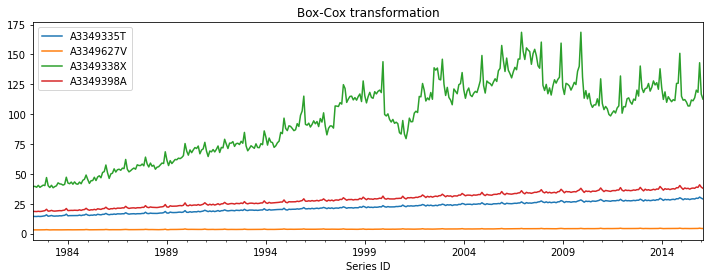

In [37]:
boxcox_model = BoxCox()
lambds = {}
bc_train = train.copy()
for col in train.columns:
    bc_train[col], lambds[col] = boxcox_model.transform_boxcox(
        train[col].values, method='loglik')
bc_train.plot(figsize=(12, 4))
plt.title('Box-Cox transformation')
plt.show()

In [38]:
lambds

{'A3349335T': 0.2849374963384148,
 'A3349338X': 0.85262045917212,
 'A3349398A': 0.3239342116951898,
 'A3349627V': -0.10305050735646222}

In [39]:
train_ds = ListDataset(
    [{'target': ts, 'start': train_start} for ts in bc_train.values.T],
    freq='M')

test_ds = ListDataset(
    [{'target': ts, 'start': test_start} for ts in bc_train.values[-60:].T],
    freq='M')

In [40]:
train_grouper = MultivariateGrouper(
    max_target_dim=4)
test_grouper = MultivariateGrouper(
    max_target_dim=4)

dataset_train = train_grouper(train_ds)
dataset_test = test_grouper(test_ds)

In [50]:
estimator = TransformerTempFlowEstimator(
    input_size=14,
    d_model=16,
    num_heads=4,
    target_dim=4,
    prediction_length=60,
    context_length=60,
    flow_type='MAF',
    dequantize=True,
    freq='M',
    trainer=Trainer(
        device=device,
        epochs=10,
        learning_rate=1e-3,
        num_batches_per_epoch=1000,
        batch_size=128))

In [51]:
predictor = estimator.train(dataset_train)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)
999it [01:58,  8.43it/s, avg_epoch_loss=-8.06, epoch=0]
999it [01:58,  8.46it/s, avg_epoch_loss=-9.23, epoch=1]
999it [01:58,  8.44it/s, avg_epoch_loss=-9.44, epoch=2]
999it [01:57,  8.50it/s, avg_epoch_loss=-9.91, epoch=3]
999it [01:58,  8.46it/s, avg_epoch_loss=-10.3, epoch=4]
999it [01:56,  8.59it/s, avg_epoch_loss=-10.7, epoch=5]
999it [01:57,  8.51it/s, avg_epoch_loss=-11.1, epoch=6]
999it [01:57,  8.53it/s, avg_epoch_loss=-11.3, epoch=7]
999it [01:57,  8.51it/s, avg_epoch_loss=-11.5, epoch=8]
999it [01:57,  8.47it/s, avg_epoch_loss=-11.6, epoch=9]


In [53]:
forecasts = list(predictor.predict(dataset_test, num_samples=100))
forecast = forecasts[0].samples
proba_forecast = np.quantile(forecast, q=[0.025, 0.5, 0.975], axis=0, )
lower_forecast = proba_forecast[0]
point_forecast = proba_forecast[1]
upper_forecast = proba_forecast[2]

In [54]:
bc_pred = pd.DataFrame(
    point_forecast, columns=test.columns, index=test.index)
bc_lower = pd.DataFrame(
    lower_forecast, columns=test.columns, index=test.index)
bc_upper = pd.DataFrame(
    upper_forecast, columns=test.columns, index=test.index)

In [55]:
pred = bc_pred.copy()
lower = bc_lower.copy()
upper = bc_upper.copy()
for col in bc_pred.columns:
    pred[col] = inv_boxcox(bc_pred[col].values, lambds[col])
    lower[col] = inv_boxcox(bc_lower[col].values, lambds[col])
    upper[col] = inv_boxcox(bc_upper[col].values, lambds[col])

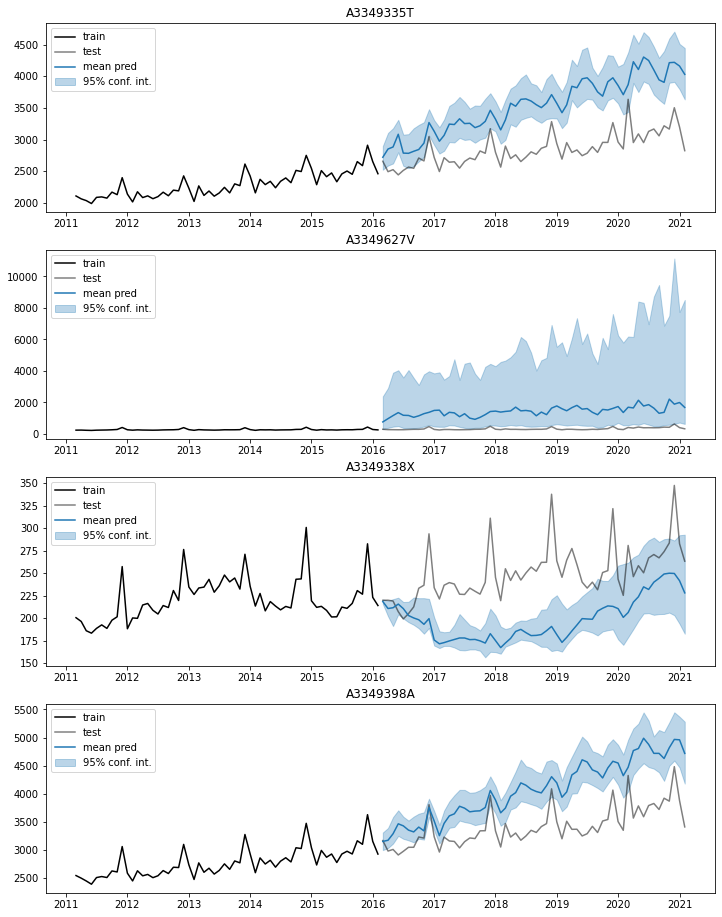

In [56]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-60:], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(pred.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)

### box cox + seasonal differencing

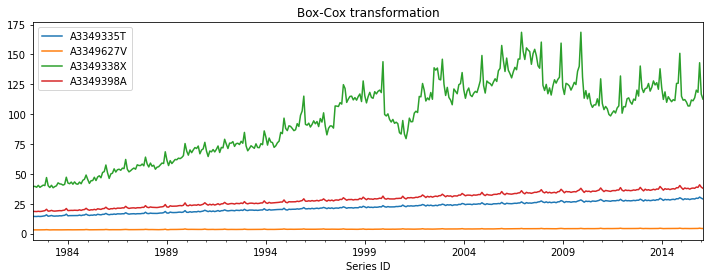

In [ ]:
boxcox_model = BoxCox()
lambds = {}
bc_train = train.copy()
for col in train.columns:
    bc_train[col], lambds[col] = boxcox_model.transform_boxcox(
        train[col].values, method='loglik')
bc_train.plot(figsize=(12, 4))
plt.title('Box-Cox transformation')
plt.show()

In [11]:
def differencing(ts, periods):
    return ts.diff(periods=periods).dropna()

def integration(ts, periods, original_ts):
    ts_concat = pd.concat([original_ts.iloc[:periods], ts])
    ts_integration = []
    for i in range(periods):
        ts_integration.append(ts_concat.iloc[i::periods].cumsum(axis=0))
    return pd.concat(ts_integration).sort_index()

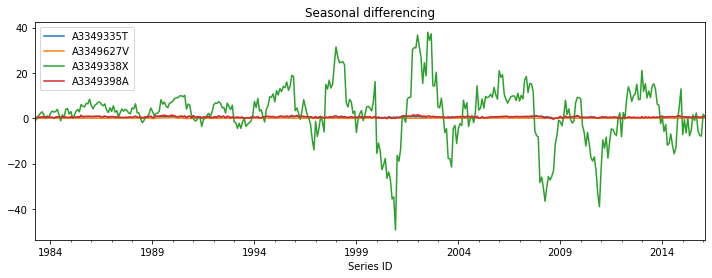

In [ ]:
seasonal_lag = 12
t_train = differencing(bc_train, seasonal_lag)
t_train.plot(figsize=(12, 4))
plt.title('Seasonal differencing')
plt.show()

In [ ]:
train_ds = ListDataset(
    [{'target': ts, 'start': train_start} for ts in t_train.values.T],
    freq='M')

test_ds = ListDataset(
    [{'target': ts, 'start': test_start} for ts in t_train.values[-60:].T],
    freq='M')

In [ ]:
train_grouper = MultivariateGrouper(
    max_target_dim=4)
test_grouper = MultivariateGrouper(
    max_target_dim=4)

dataset_train = train_grouper(train_ds)
dataset_test = test_grouper(test_ds)

In [ ]:
estimator = TransformerTempFlowEstimator(
    input_size=14,
    d_model=16,
    num_heads=4,
    target_dim=4,
    prediction_length=60,
    context_length=60,
    flow_type='MAF',
    dequantize=True,
    freq='M',
    trainer=Trainer(
        device=device,
        epochs=16,
        learning_rate=0.1,
        num_batches_per_epoch=100,
        batch_size=64))

In [ ]:
predictor = estimator.train(dataset_train)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)
99it [00:04, 21.12it/s, avg_epoch_loss=6.74, epoch=0]
98it [00:04, 21.27it/s, avg_epoch_loss=5.84, epoch=1]
98it [00:04, 21.13it/s, avg_epoch_loss=5.3, epoch=2] 
97it [00:04, 20.81it/s, avg_epoch_loss=4.85, epoch=3]
99it [00:04, 21.45it/s, avg_epoch_loss=4.56, epoch=4]
98it [00:04, 21.25it/s, avg_epoch_loss=4.24, epoch=5]
99it [00:04, 21.54it/s, avg_epoch_loss=4.02, epoch=6]
98it [00:04, 21.45it/s, avg_epoch_loss=3.8, epoch=7]
98it [00:04, 21.36it/s, avg_epoch_loss=3.67, epoch=8]
99it [00:04, 21.31it/s, avg_epoch_loss=3.51, epoch=9]
99it [00:04, 21.24it/s, avg_epoch_loss=3.37, epoch=10]
99it [00

In [ ]:
forecasts = list(predictor.predict(dataset_test, num_samples=1000))
forecast = forecasts[0].samples
proba_forecast = np.quantile(forecast, q=[0.025, 0.5, 0.975], axis=0, )
lower_forecast = proba_forecast[0]
point_forecast = proba_forecast[1]
upper_forecast = proba_forecast[2]

/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)


In [ ]:
point_forecast = pd.DataFrame(
    point_forecast, columns=test.columns, index=test.index)
lower_forecast = pd.DataFrame(
    lower_forecast, columns=test.columns, index=test.index)
upper_forecast = pd.DataFrame(
    upper_forecast, columns=test.columns, index=test.index)

In [ ]:
pred = point_forecast.copy()
lower = lower_forecast.copy()
upper = upper_forecast.copy()

In [ ]:
bc_pred = integration(point_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_lower = integration(lower_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_upper = integration(upper_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_pred.shape

(60, 4)

In [ ]:
bc_lower[bc_lower < 0] = 0

In [ ]:
pred = bc_pred.copy()
lower = bc_lower.copy()
upper = bc_upper.copy()
for col in bc_pred.columns:
    pred[col] = inv_boxcox(bc_pred[col].values, lambds[col])
    lower[col] = inv_boxcox(bc_lower[col].values, lambds[col])
    upper[col] = inv_boxcox(bc_upper[col].values, lambds[col])
pred.head()

,A3349335T,A3349627V,A3349338X,A3349398A
Series ID,,,,
2016-03-01,2724.263180,443.808967,216.353775,3258.265055
2016-04-01,2639.562772,482.427035,207.855105,3135.802034
2016-05-01,2704.989054,499.052931,197.230279,3197.026528
2016-06-01,2565.155506,479.592907,196.984542,3041.037901
2016-07-01,2688.883748,505.248227,204.027062,3188.666992


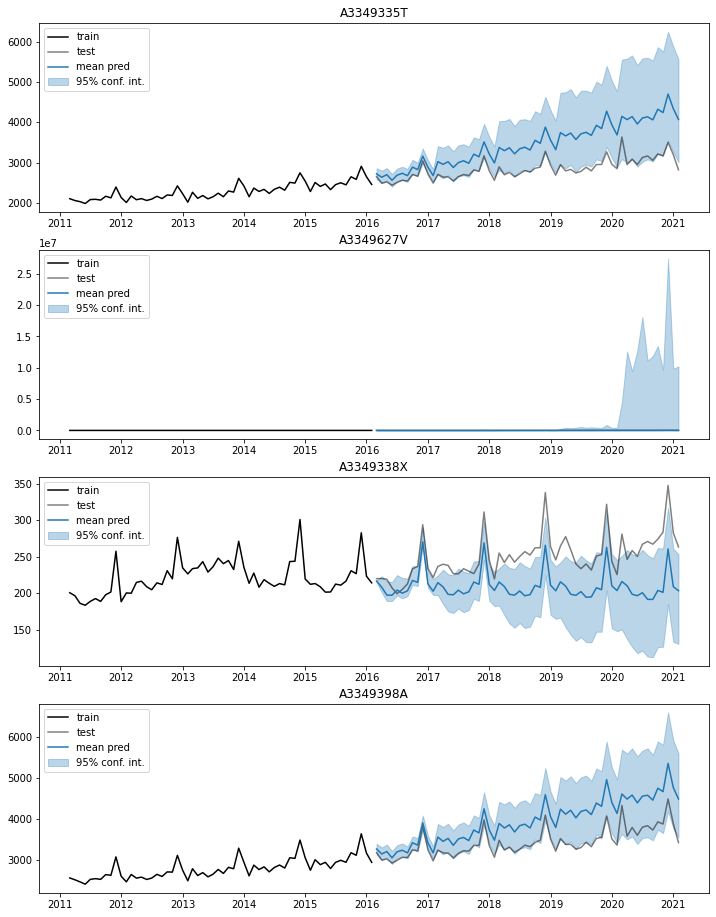

In [ ]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-60:], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(pred.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)

### only seasonal

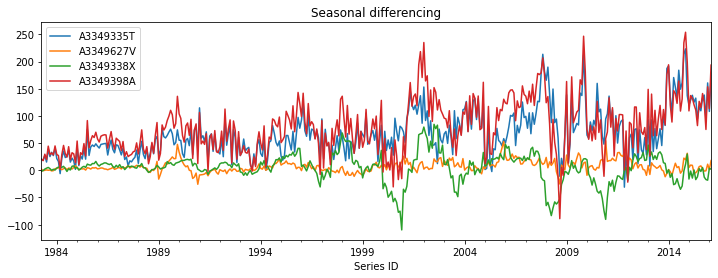

In [12]:
seasonal_lag = 12
t_train = differencing(train, seasonal_lag)
t_train.plot(figsize=(12, 4))
plt.title('Seasonal differencing')
plt.show()

In [13]:
train_ds = ListDataset(
    [{'target': ts, 'start': train_start} for ts in t_train.values.T],
    freq='M')

test_ds = ListDataset(
    [{'target': ts, 'start': test_start} for ts in t_train.values[-60:].T],
    freq='M')

In [14]:
train_grouper = MultivariateGrouper(
    max_target_dim=4)
test_grouper = MultivariateGrouper(
    max_target_dim=4)

dataset_train = train_grouper(train_ds)
dataset_test = test_grouper(test_ds)

In [15]:
estimator = TransformerTempFlowEstimator(
    input_size=14,
    d_model=16,
    num_heads=4,
    target_dim=4,
    prediction_length=60,
    context_length=60,
    flow_type='MAF',
    dequantize=True,
    freq='M',
    trainer=Trainer(
        device=device,
        epochs=10,
        learning_rate=0.1,
        num_batches_per_epoch=1000,
        batch_size=128))

In [17]:
predictor = estimator.train(dataset_train)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)
999it [00:59, 16.87it/s, avg_epoch_loss=-.22, epoch=0] 
998it [00:57, 17.25it/s, avg_epoch_loss=-4.37, epoch=1]
998it [00:58, 17.06it/s, avg_epoch_loss=-6.16, epoch=2]
998it [00:58, 17.18it/s, avg_epoch_loss=-7.26, epoch=3]
998it [00:57, 17.21it/s, avg_epoch_loss=-8.17, epoch=4]
998it [00:57, 17.33it/s, avg_epoch_loss=-8.92, epoch=5]
998it [00:57, 17.34it/s, avg_epoch_loss=-9.63, epoch=6]
998it [00:58, 17.20it/s, avg_epoch_loss=-10.2, epoch=7]
998it [00:57, 17.37it/s, avg_epoch_loss=-10.7, epoch=8]
998it [00:57, 17.39it/s, avg_epoch_loss=-11.1, epoch=9]


In [19]:
forecasts = list(predictor.predict(dataset_test, num_samples=100))
forecast = forecasts[0].samples
proba_forecast = np.quantile(forecast, q=[0.025, 0.5, 0.975], axis=0, )
lower_forecast = proba_forecast[0]
point_forecast = proba_forecast[1]
upper_forecast = proba_forecast[2]

In [20]:
point_forecast = pd.DataFrame(
    point_forecast, columns=test.columns, index=test.index)
lower_forecast = pd.DataFrame(
    lower_forecast, columns=test.columns, index=test.index)
upper_forecast = pd.DataFrame(
    upper_forecast, columns=test.columns, index=test.index)

In [21]:
pred = integration(point_forecast, seasonal_lag, train.iloc[-seasonal_lag:]).iloc[-60:]
lower = integration(lower_forecast, seasonal_lag, train.iloc[-seasonal_lag:]).iloc[-60:]
upper = integration(upper_forecast, seasonal_lag, train.iloc[-seasonal_lag:]).iloc[-60:]
pred.shape

(60, 4)

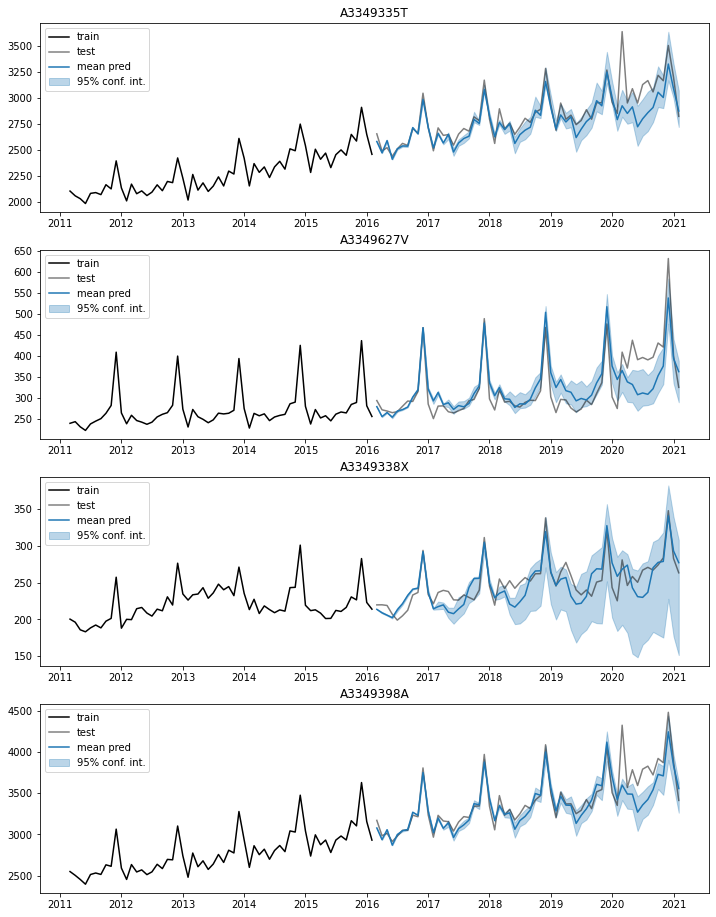

In [22]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-60:], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(pred.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)

In [23]:
y_pred = np.stack([lower.values, pred.values, upper.values], axis=2)
print('Quantile loss: {:.4f}'.format(quantile_loss(y_pred, test.values)))

Quantile loss: 0.0635


In [25]:
gen_corr = np.corrcoef(forecast.reshape(4, 100*60))
test_corr = np.corrcoef(test.values.T)

print('Correlation loss: {:.4f}'.format(mse(gen_corr, test_corr)))

Correlation loss: 0.0020


In [26]:
generated_ts = forecast

nlags = 20
nts = generated_ts.shape[2]
ngen = generated_ts.shape[0]
gen_pacfs = np.zeros((ngen, nts, nlags))
for gen_id in range(ngen):
    for ts_id in range(nts):
        gen_pacfs[gen_id, ts_id] = pacf(generated_ts[gen_id, :, ts_id], nlags=nlags)[1:]
gen_pacfs = gen_pacfs.mean(axis=0)

test_pacfs = np.zeros((nts, nlags))
for ts_id in range(nts):
    test_pacfs[ts_id] = pacf(test.values[:, ts_id], nlags=nlags)[1:]

print('PACF loss: {:.4f}'.format(mse(gen_pacfs, test_pacfs)))

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


PACF loss: 0.0750
